# Linear regressions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from matplotlib import colors as colorsm

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

In [3]:
from scipy.stats import pearsonr, linregress, zscore, gmean, shapiro, kstest, spearmanr, boxcox, rankdata, kendalltau, norm, t

In [4]:
from skbio import TreeNode

In [5]:
from matplotlib.ticker import ScalarFormatter

In [6]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [7]:
from scipy.stats import gaussian_kde, mannwhitneyu, ttest_ind, levene
from scipy.interpolate import griddata

In [8]:
from pylr2 import regress2

In [9]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 15,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [10]:
def sig_sign(p):
    if p > 0.05:
        return 'ns'
    elif p > 0.01:
        return '*'
    elif p > 0.001:
        return '**'
    elif p > 0.0001:
        return '***'
    else:
        return '****'

Load data

In [11]:
df = pd.read_table('place/fine_all.tsv', index_col = 0)
df.shape

(5380, 28)

In [12]:
def ref_shape(s):
    """Reformat "shape column".
    """
    if 'shaped' in s:
        s = s.split('-')[0]
    elif s == 'sphere/spheroid':
        return 'sphere'
    elif s == 'rods':
        return 'rod'
    elif '/' in s:
        s = '-'.join(s.split('/'))
    if s in ('ovoid', 'oval', 'ellipsoidal'):
        return 'ovoid'
    elif s == 'pear':
        return 'sphere'
    elif s in ('sphere', 'spherical'):
        return 'sphere'
    else:
        return s

In [13]:
df['shape'] = df['shape'].fillna('').map(ref_shape)

Equivalent spherical diameter

In [14]:
df['equivalent_spherical'] = np.cbrt((6 * df['volume_gmean']) / np.pi)
df['log_equivalent_spherical'] = np.log10(df['equivalent_spherical'])

In [15]:
df['volume_sphere'] = (np.pi / 6) * (df['equivalent_spherical'] ** 3)
df['surface_sphere'] = np.pi * (df['equivalent_spherical'] ** 2)

In [16]:
df['log_volume_sphere'] = np.log10(df['volume_sphere'])
df['log_surface_sphere'] = np.log10(df['surface_sphere'])

Arcsine transformation for proportional data

In [17]:
df['arc_coding'] = np.arcsin(np.sqrt(df['coding'] / 100))
df['arc_gc'] = np.arcsin(np.sqrt(df['gc'] / 100))

Log transformation of other variables

In [18]:
for col in ['genome', 'proteins']:
    df[f'log_{col}'] = np.log10(df[col])

### Get species with available genomic information

In [19]:
df1 = df[df['node'].str.contains('G')].copy()

**Because of our methodology (phylogenetic placement) some species have been assigned to the same genome, so we need to get rid of the duplicates and select only those species whose taxonomic name matches the genome name**

In [20]:
dft = pd.read_table('../phylogeny/tax2tree/filled_ranks.tsv', index_col = 0)

In [21]:
df1['is_species'] = df1['node'].apply(lambda x: dft.loc[x]['species'] if x in dft.index else np.nan)

In [22]:
df1 = df1[df1['species'] == df1['is_species']]

In [23]:
df1.shape

(1363, 39)

Load tree

In [24]:
tree = TreeNode.read('place/fine_all.nwk')
print(f'Tree tips {tree.count()}')
print(f'Tree tips {tree.count(tips = True)}')

Tree tips 7341
Tree tips 5380


Prune tree to contain only taxa with genomic information

In [25]:
woltree = tree.copy()

In [26]:
woltree = woltree.shear(df1.index)
woltree.prune()

In [27]:
print(f'Tree tips {woltree.count()}')
print(f'Tree tips {woltree.count(tips = True)}')

Tree tips 2695
Tree tips 1363


### Spearman's correlation

In [32]:
cols = ['log_volume_sphere', 'log_genome', 'log_proteins', 'arc_gc', 'arc_coding', 'rrnas', 'ENCprime']

In [33]:
xlabels = ['Log (Volume, $\\mu m$)',
           'Log(Genome\nsize, bp)', 'Log(Number\nof proteins)', 'Arcsine(GC\ncontent, %)', 
          'Arcsine(Coding\ndensity, %)', '16S rRNA\ncopies', "$\\Delta$ENC\'"]

In [34]:
dfc = spearmanr(df1[cols])

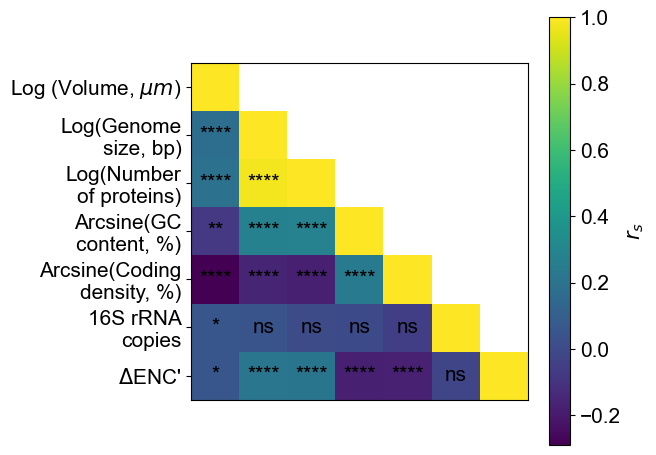

In [35]:
fig, ax = plt.subplots()

# Lower triangular
mask = np.triu(np.ones_like(dfc[0], dtype = bool), k = 1)
# Upper triangular
# mask = np.tri(dfc[0].shape[0], k = -1)

data = np.ma.array(dfc[0], mask = mask)
im = ax.imshow(data,  cmap = 'viridis')

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(xlabels)
plt.setp(ax.get_xticklabels(), rotation = 90, ha = "center")

cb = fig.colorbar(im, ax = ax, orientation = 'vertical', location = 'right')
cb.set_label('$r_s$')

# Text annotation with pvalues
for i in range(len(cols)):
    for j in range(len(cols)):
        if  i > j:
            text = plt.text(j, i, sig_sign(dfc[1][i, j]),
                           ha = "center", va = "center", color = "black")
plt.show()

### Linear regressions

In [37]:
cols = ['log_genome', 'log_proteins', 'arc_gc', 'arc_coding', 'rrnas', 'ENCprime']

In [38]:
ylabels = ['Log(Genome size, bp)', 'Log(Number of proteins)', 'Arcsine(GC content, %)', 
          'Arcsine(Coding density, %)', '16S rRNA copies', "$\\Delta$ENC\'"]

In [39]:
degrees_freedom = len(df1['log_volume_sphere']) - 2
alpha = 0.05
critical_value = t.pdf(1 - alpha / 2, degrees_freedom)


Genome property: log_genome
OLS summary:                             OLS Regression Results                            
Dep. Variable:             log_genome   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     79.09
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.84e-18
Time:                        20:22:01   Log-Likelihood:                 421.37
No. Observations:                1363   AIC:                            -838.7
Df Residuals:                    1361   BIC:                            -828.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

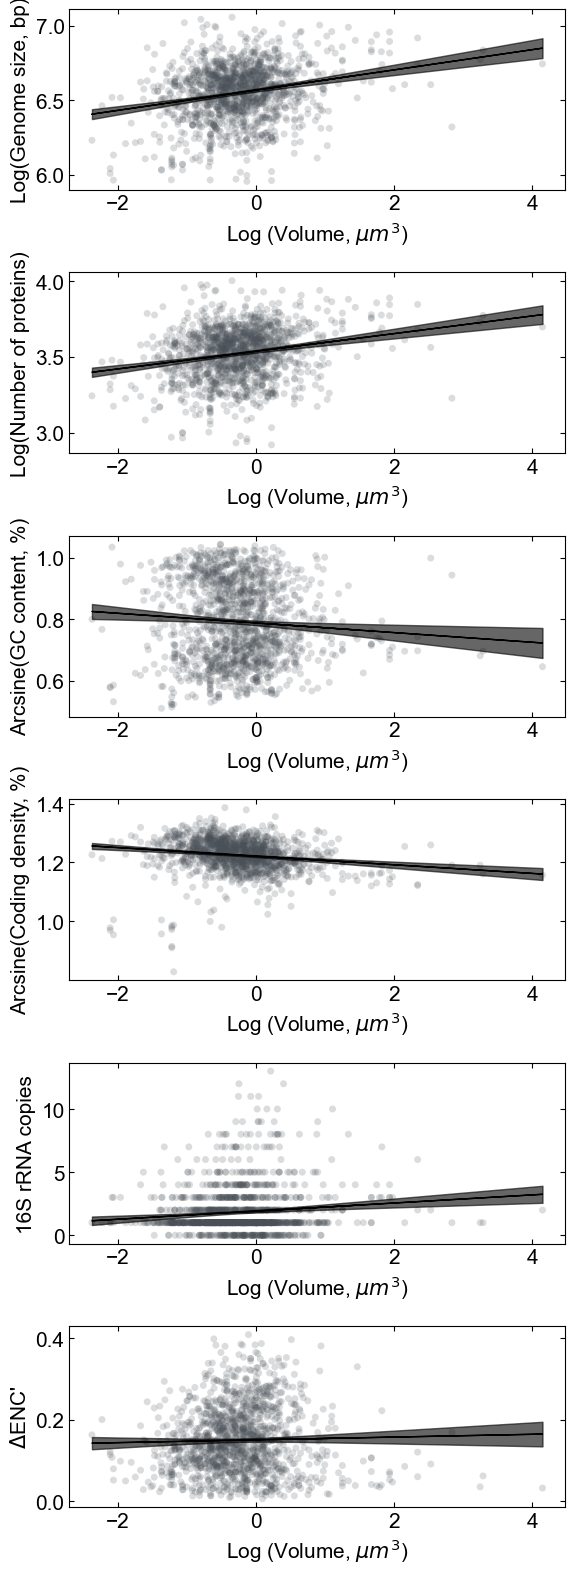

In [42]:
fig, ax = plt.subplots(len(cols), 1, figsize = (6, 16))

size = 'log_volume_sphere'
for i, col in enumerate(cols):
    
    x = sm.add_constant(df1[size])
    y = df1[col]
    reg = sm.OLS(y, x).fit()
    intercept, slope = reg.params
        
    x_ = np.linspace(df1[size].min(), df1[size].max(), df1[size].shape[0])
    y_pred = reg.get_prediction(sm.add_constant(x_))
        
    residuals = y - reg.predict()
    parameters = norm.fit(residuals)
    KS = kstest(residuals, 'norm', parameters)
    
        
    # Plots - OLS
    ax[i].scatter(df1[size], y, alpha = 0.2, ec = 'none', color = '#495057', s = 25)
    ax[i].plot(df1[size], (df1[size] * slope + intercept), c= 'k', lw = 1)
    ax[i].fill_between(x_, *zip(*y_pred.conf_int()), color = 'k', alpha = 0.6)
    ax[i].set_xlabel(f'Log (Volume, $\\mu m^3$)')
    ax[i].set_ylabel(f'{ylabels[i]}')
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
       
    # Spearman correlation coefficient
    pr = spearmanr(df1[size], y)
    
    print(f'\nGenome property: {col}')
    print(f'OLS summary: {reg.summary()}')
    print(f'Nomality residuals: {KS}')
    print(f'Spearman rank correlation: {pr}')
    
plt.show()

### Only perfect spheres

In [43]:
df1['aspect_ratio'] = df1['length_gmean'] / df1['width_gmean']

In [45]:
df2 = df1[df1['aspect_ratio'] == 1]

In [46]:
degrees_freedom = len(df2['log_volume_sphere']) - 2
alpha = 0.05
critical_value = t.pdf(1 - alpha / 2, degrees_freedom)


Genome property: log_genome
OLS summary:                             OLS Regression Results                            
Dep. Variable:             log_genome   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     69.51
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           2.93e-14
Time:                        20:24:38   Log-Likelihood:                 32.400
No. Observations:                 166   AIC:                            -60.80
Df Residuals:                     164   BIC:                            -54.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

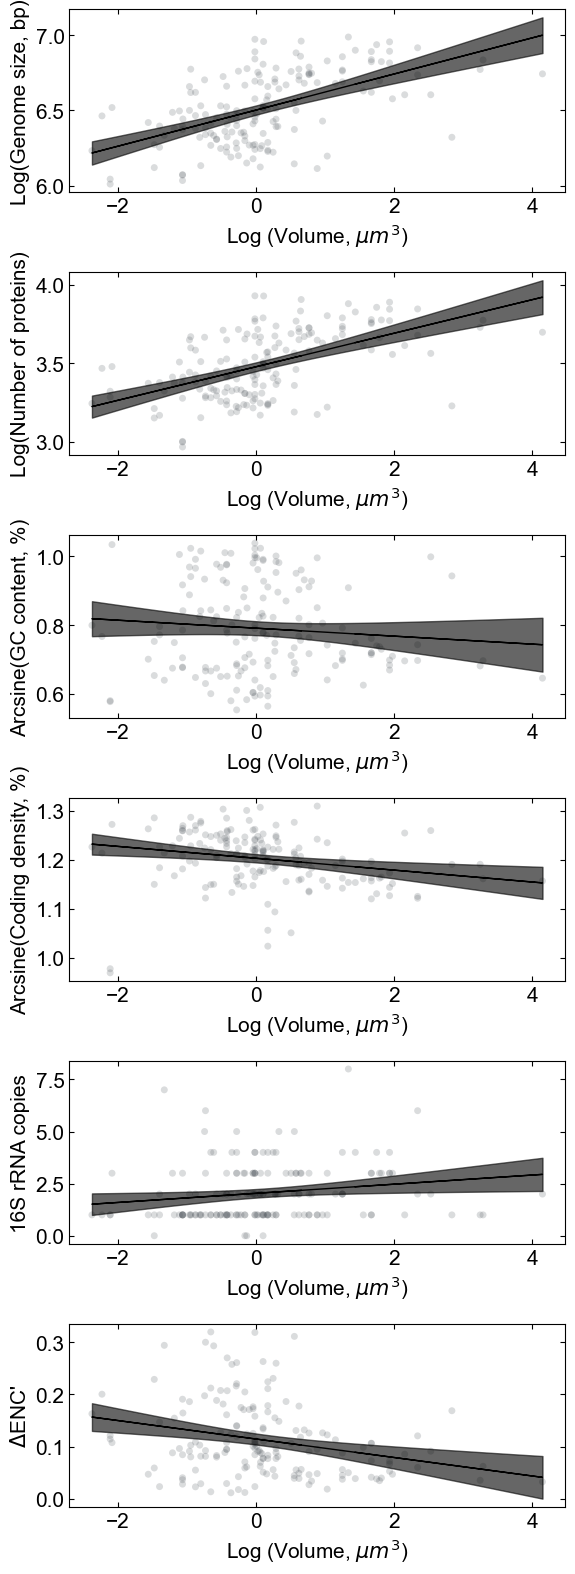

In [47]:
fig, ax = plt.subplots(len(cols), 1, figsize = (6, 16))

size = 'log_volume_sphere'
for i, col in enumerate(cols):
    
    x = sm.add_constant(df2[size])
    y = df2[col]
    reg = sm.OLS(y, x).fit()
    intercept, slope = reg.params
        
    x_ = np.linspace(df2[size].min(), df2[size].max(), df2[size].shape[0])
    y_pred = reg.get_prediction(sm.add_constant(x_))
        
    residuals = y - reg.predict()
    parameters = norm.fit(residuals)
    KS = kstest(residuals, 'norm', parameters)
    
        
    # Plots - OLS
    ax[i].scatter(df2[size], y, alpha = 0.2, ec = 'none', color = '#495057', s = 25)
    ax[i].plot(df2[size], (df2[size] * slope + intercept), c= 'k', lw = 1)
    ax[i].fill_between(x_, *zip(*y_pred.conf_int()), color = 'k', alpha = 0.6)
    ax[i].set_xlabel(f'Log (Volume, $\\mu m^3$)')
    ax[i].set_ylabel(f'{ylabels[i]}')
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
       
    # Spearman correlation coefficient
    pr = spearmanr(df2[size], y)
    
    print(f'\nGenome property: {col}')
    print(f'OLS summary: {reg.summary()}')
    print(f'Nomality residuals: {KS}')
    print(f'Spearman rank correlation: {pr}')
    
plt.show()